# Task

Use the popular student [competition case](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description).

1. Read the training sample to a Pandas dataframe.
1. Extending Assignment 1, now consider multiple linear regression models.
$$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_Kx_K + \epsilon$$
1. Choose **one** multiple linear regression model and make predictions from the test data set.
  - Clearly, model choice is an art now...
  - Possibly, use **forward search** or backward search,
  - or try **Benjamini-Hochberg method**,
  - or consider some **K-fold method for model selection**,
  - or use some economic theory / literature to select key variables,
  - or create new variables based on existing ones.
  - This is a typical example of open-ended questions.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.



**Warning:** many NA values in both training and testing samples.

# **Import the library**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import itertools
import statsmodels.formula.api as smf
from patsy.builtins import Q
import matplotlib.pyplot as plt
import imp
from sklearn.model_selection import KFold
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from matplotlib.backends.backend_pdf import PdfPages

!pip install kaleido

# **Read the training sample to a Pandas dataframe.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_file_path ="https://www.dropbox.com/scl/fi/jwa0otrhc47p1qbxhn7vn/train.csv?rlkey=cphiqc3g7id0ewvvkzzwtjnus&dl=1"
train_df = pd.read_csv(train_file_path)
#train_df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Replace missing values with median**

In [ ]:
# Calculate the median of each column
column_medians = train_df.median()

# Replace missing values in each column with the respective column's median
train_df = train_df.fillna(column_medians)

<ipython-input-3-a15ffbb40a05>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_medians = train_df.median()


# **The distribution of the SalePrice and its skewness and kurtosis.**

<ipython-input-4-12d5a273c5e0>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='cornflowerblue', bins=100, hist_kws={'alpha': 0.4})


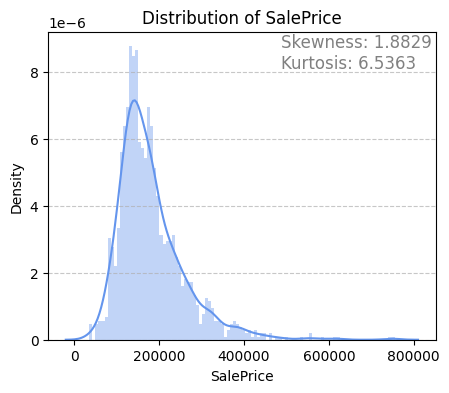

In [ ]:
# Calculate skewness and kurtosis for the SalePrice
saleprice_skewness = train_df['SalePrice'].skew()
saleprice_kurtosis = train_df['SalePrice'].kurtosis()

# Display the skewness and kurtosis values with 4 decimal places
skew_text = f"Skewness: {saleprice_skewness:.4f}"
kurtosis_text = f"Kurtosis: {saleprice_kurtosis:.4f}"

# Plot the histogram
plt.figure(figsize=(5, 4))
sns.distplot(train_df['SalePrice'], color='cornflowerblue', bins=100, hist_kws={'alpha': 0.4})

# Add text annotations for skewness and kurtosis
plt.text(0.6, 0.95, skew_text, transform=plt.gca().transAxes, fontsize=12,color='gray')
plt.text(0.6, 0.88, kurtosis_text, transform=plt.gca().transAxes, fontsize=12,color='gray')

# Customize the plot
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Distribution of SalePrice')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# **Correlations of explanatory variables with the Log_SalePrice**

In [ ]:
# Calculate the correlations of explanatory variables with the log level of sale price ('y')

train_df['Log_SalePrice'] = np.log(train_df['SalePrice'])

# calculate correlations with the transformed 'Log_SalePrice' column
correlations_log = train_df.corr(numeric_only=True)['Log_SalePrice']

sorted_correlations_log = correlations_log.abs().sort_values(ascending=False)

# Create a new DataFrame with two columns: 'Absolute_Correlation' and 'Original_Correlation'
result_df_log = pd.DataFrame({
    'Absolute_Correlation': sorted_correlations_log,
    'Original_Correlation': correlations_log
})

# Sort the DataFrame by 'Absolute_Correlation' column in descending order
result_df_log = result_df_log.sort_values(by='Absolute_Correlation', ascending=False)

top_five_results = result_df_log.head(20)

print(top_five_results)

               Absolute_Correlation  Original_Correlation
Log_SalePrice              1.000000              1.000000
SalePrice                  0.948374              0.948374
OverallQual                0.817184              0.817184
GrLivArea                  0.700927              0.700927
GarageCars                 0.680625              0.680625
GarageArea                 0.650888              0.650888
TotalBsmtSF                0.612134              0.612134
1stFlrSF                   0.596981              0.596981
FullBath                   0.594771              0.594771
YearBuilt                  0.586570              0.586570
YearRemodAdd               0.565608              0.565608
TotRmsAbvGrd               0.534422              0.534422
GarageYrBlt                0.495794              0.495794
Fireplaces                 0.489449              0.489449
MasVnrArea                 0.426775              0.426775
BsmtFinSF1                 0.372023              0.372023
LotFrontage   

# **Top Six Correlation Plot**

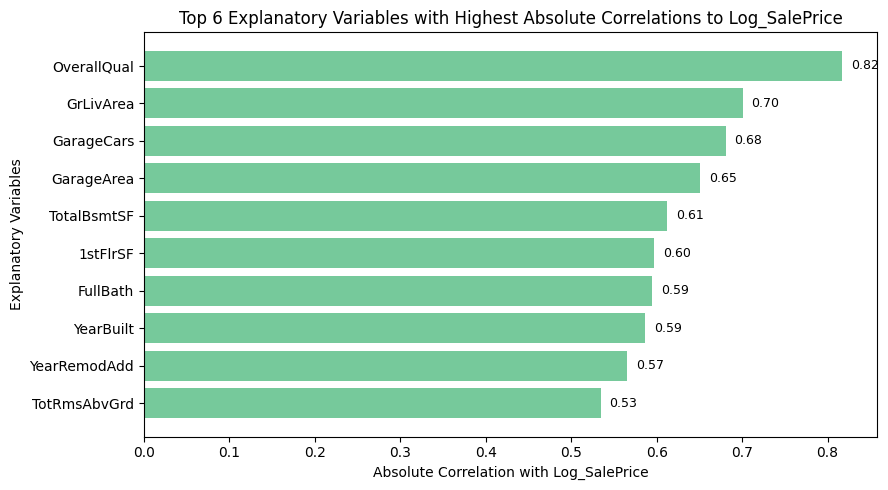

In [ ]:
plt.figure(figsize=(9, 5))

# Drop 'Log_SalePrice' and 'SalePrice' from the DataFrame
result_df_log_filtered = result_df_log.drop(['Log_SalePrice', 'SalePrice'])

# Sort the DataFrame by 'Absolute_Correlation' column in descending order
result_df_log_filtered = result_df_log_filtered.sort_values(by='Absolute_Correlation', ascending=True)

# Select the top 6 explanatory variables
top_variables = result_df_log_filtered.tail(10)

# Set the colors for the bar chart
colors = "mediumseagreen"

# Plot the correlations using a bar chart
ax = plt.barh(np.arange(len(top_variables)), top_variables['Absolute_Correlation'], color=colors, alpha=0.7)

# Add data labels on the bars
for i, v in enumerate(top_variables['Original_Correlation']):
    plt.text(v + 0.01, i, f'{v:.2f}', ha='left', va='center', fontsize=9)

# Customize the plot
plt.yticks(np.arange(len(top_variables)), top_variables.index)
plt.xlabel('Absolute Correlation with Log_SalePrice')
plt.ylabel('Explanatory Variables')
plt.title('Top 6 Explanatory Variables with Highest Absolute Correlations to Log_SalePrice')
plt.tight_layout()

# Show the plot
plt.show()


# **Average Value for Sale Price and Different Neighborhood**

In [ ]:
unique_neighborhoods = train_df['Neighborhood'].unique()
num_unique_neighborhoods = len(unique_neighborhoods)
num_unique_neighborhoods # number of neighborhoods

25

In [ ]:
saleprice_mean = train_df['SalePrice'].mean()
means_by_neibour = train_df.groupby("Neighborhood")["SalePrice"].mean()
sorted_mean = means_by_neibour.sort_values(ascending=False)
print(sorted_mean)
saleprice_mean

Neighborhood
NoRidge    335295.317073
NridgHt    316270.623377
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Somerst    225379.837209
ClearCr    212565.428571
Crawfor    210624.725490
CollgCr    197965.773333
Blmngtn    194870.882353
Gilbert    192854.506329
NWAmes     189050.068493
SawyerW    186555.796610
Mitchel    156270.122449
NAmes      145847.080000
NPkVill    142694.444444
SWISU      142591.360000
Blueste    137500.000000
Sawyer     136793.135135
OldTown    128225.300885
Edwards    128219.700000
BrkSide    124834.051724
BrDale     104493.750000
IDOTRR     100123.783784
MeadowV     98576.470588
Name: SalePrice, dtype: float64


180921.19589041095

Based on the above data, we know that there are great differences between different neighborhoods. Therefore, creating neighborhood as dummy variable.

# **Base on Assignment 1 Model to choose model**
## Transform the Data

In [ ]:
### transform SalePrice to log_saleprice
train_df['Log_SalePrice'] = np.log(train_df['SalePrice'])
### add intercept
train_df = sm.add_constant(train_df)
train_df

,const,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Log_SalePrice
0,1.0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,1.0,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,1.0,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,1.0,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,1.0,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,12.072541
1456,1.0,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,12.254863
1457,1.0,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,12.493130
1458,1.0,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,11.864462


# Set Neighborhood as Dummy Variable

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
dummy_variables = pd.DataFrame(encoder.fit_transform(train_df[['Neighborhood']]))
dummy_variables.columns = encoder.get_feature_names_out()
train_df = pd.concat([train_df, dummy_variables], axis=1)
train_df

,const,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,1.0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,1.0,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,1.0,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,1.0,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Relevant variables selected based on literature and fitted with OLS

Summary table saved as model_1_results_summary.png


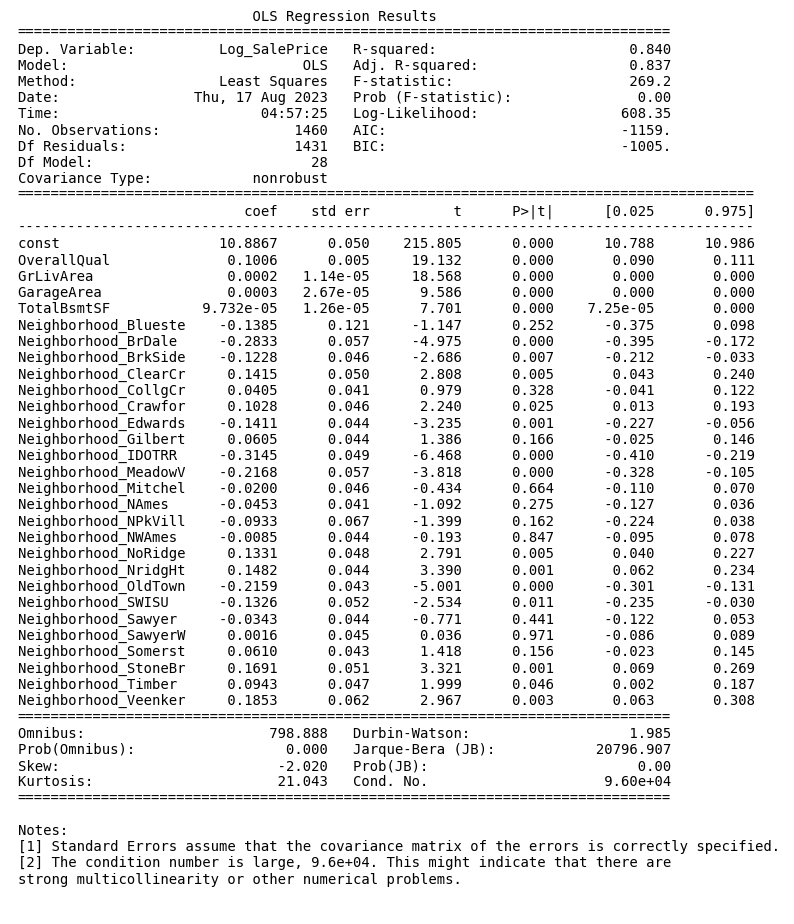

In [ ]:
X_list = ['const', 'OverallQual','GrLivArea','GarageArea','TotalBsmtSF'] + dummy_variables.columns.values.tolist()
X_train = train_df[X_list]
y = train_df['Log_SalePrice']

stats_model = sm.OLS(y, X_train)
results = stats_model.fit()

#print(results.summary())

# Create a Figure for the summary table
summary_fig = plt.figure(figsize=(10, 8))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')

# Save the Figure as a PNG image
png_filename = 'model_1_results_summary.png'
summary_fig.savefig(png_filename, bbox_inches='tight', dpi=300)

print(f"Summary table saved as {png_filename}")

# **Using Benjamini-Hochberg method to select model**

In [ ]:
pvalues = results.pvalues
fig = px.histogram(x=pvalues)
fig.update_layout(
    title='p values',
    xaxis=dict(title='p values'),
    yaxis=dict(title='count'),
)

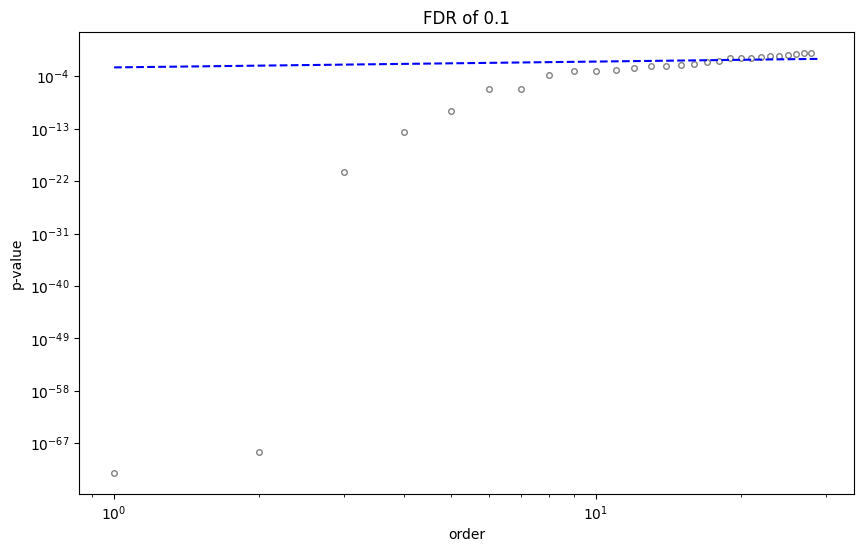

In [ ]:
def fdr_cut(pvalues, q=0.1):
    # q=0.1 is the default value. if no q input, it is set as 0.1
    pvalues = np.sort(pvalues[~np.isnan(pvalues)])
    N = len(pvalues)
    k = np.argsort(pvalues, kind='mergesort') + 1  # The method to deal with ties in ranking is "min"

    alpha = np.max(pvalues[pvalues <= (q * k / N)])

    plt.figure(figsize=(10, 6))
    plt.plot(pvalues, 'o', markersize=4, markerfacecolor='none', markeredgecolor='gray')
    plt.plot(np.arange(1, N + 1), q * np.arange(1, N + 1) / N, color='blue', linestyle='--')
    plt.xlabel('order')
    plt.ylabel('p-value')
    plt.title(f'FDR of {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('FDR of 0.1.png')

    return alpha

alpha = fdr_cut(pvalues)
plt.show()

0.045851122401938296

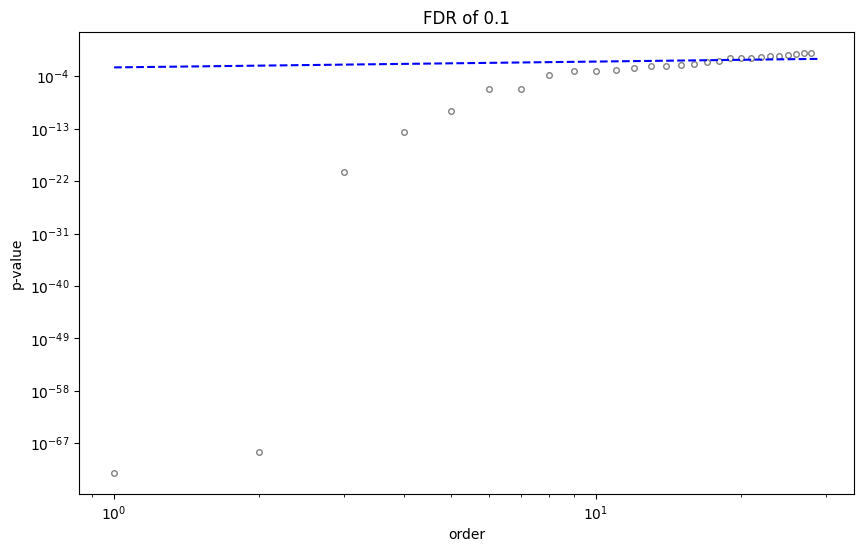

In [ ]:
fdr_cut(pvalues)

According to the Benjamini-Hochberg method, variables with a P-value less than 0.04585 should be selected. Now all the variables used to fit the multiple linear regression model should be kept.

# **Method 2: forward search method**

In [ ]:
# filter the vaiable that is important and realistic
filtered_train_df = train_df[['Log_SalePrice', 'OverallQual','GrLivArea',
                              'GarageArea','TotalBsmtSF','1stFlrSF',
                              'FullBath','YearBuilt','YearRemodAdd',
                              'LotFrontage','OpenPorchSF']]

In [ ]:
# Define the target column
target_column = 'Log_SalePrice'

# Create a list of potential predictor variables
predictor_columns = ['OverallQual', 'GrLivArea', 'GarageArea',
                     'TotalBsmtSF', '1stFlrSF', 'FullBath',
                     'YearBuilt', 'YearRemodAdd', 'LotFrontage',
                     'OpenPorchSF']

# Initialize variables for best model and AICc
best_aicc = float('inf')
best_model = None

# Create a DataFrame to store AICc values
aicc_table = pd.DataFrame(columns=['Model', 'AICc'])

# Loop through models with increasing number of predictors
for k in range(1, len(predictor_columns) + 1):
    best_subset = None
    best_subset_aicc = float('inf')

    # Iterate through all combinations of predictor columns
    for subset in itertools.combinations(predictor_columns, k):
        formula = f"{target_column} ~ {' + '.join(subset)}"
        X = filtered_train_df[list(subset)]
        y = filtered_train_df[target_column]

        model = sm.OLS(y, sm.add_constant(X))
        result = model.fit()
        aicc = result.aic - 2 * (k + 1) * (k + 2) / (len(filtered_train_df) - k - 2)

        if aicc < best_subset_aicc:
            best_subset_aicc = aicc
            best_subset = subset

    # After trying all combinations, fit the best model for this iteration
    formula = f"{target_column} ~ {' + '.join(best_subset)}"
    X = filtered_train_df[list(best_subset)]
    y = filtered_train_df[target_column]

    model = sm.OLS(y, sm.add_constant(X))
    result = model.fit()

    # Store AICc value in the DataFrame
    aicc_table = aicc_table.append({'Model': formula, 'AICc': best_subset_aicc}, ignore_index=True)

    # Check if this model has the smallest AICc so far
    if best_subset_aicc < best_aicc:
        best_aicc = best_subset_aicc
        best_model = result

best_model
# Display summary of the best model
print("Best Model:")
print(best_model.summary())

# Display the AICc table in tabular format
print("\nAICc Table:")
print(tabulate(aicc_table, headers='keys', tablefmt='grid'))

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

Best Model:
                            OLS Regression Results                            
Dep. Variable:          Log_SalePrice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     810.2
Date:                Thu, 17 Aug 2023   Prob (F-statistic):               0.00
Time:                        04:58:04   Log-Likelihood:                 508.67
No. Observations:                1460   AIC:                            -999.3
Df Residuals:                    1451   BIC:                            -951.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4575      0.543  

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-16-e0416d4ce4b8>:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Summary table saved as model_2_results_summary.png


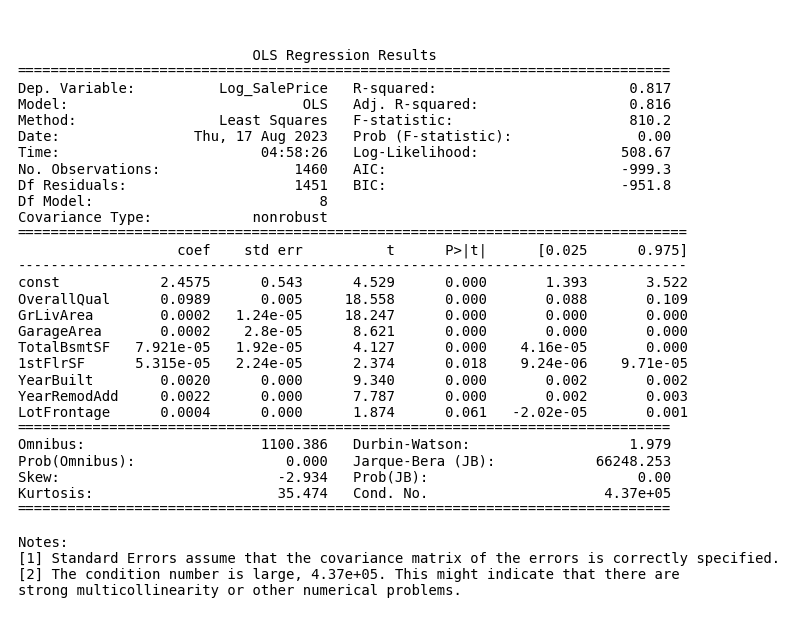

In [ ]:
# Create a Figure for the summary table
summary_fig = plt.figure(figsize=(10, 8))
plt.text(0.01, 0.05, str(best_model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')

# Save the Figure as a PNG image
png_filename = 'model_2_results_summary.png'
summary_fig.savefig(png_filename, bbox_inches='tight', dpi=300)

print(f"Summary table saved as {png_filename}")

# **Compare the two model using the k-fold cross validation method**

In [ ]:
# Number of folds (K)
K = 5

# Initialize KFold object
kf = KFold(n_splits=K, shuffle=True, random_state=12)

# Define the target column
target_column = 'Log_SalePrice'

# Define the list of predictor variables
predictor_columns_1 = ['const', 'OverallQual','GrLivArea','GarageArea','TotalBsmtSF'] + dummy_variables.columns.values.tolist()
predictor_columns_2 =  ['OverallQual', 'GrLivArea', 'GarageArea',
                     'TotalBsmtSF', '1stFlrSF',  'YearBuilt',
                      'YearRemodAdd', 'LotFrontage']

deviance_full_1 = np.zeros(K) # Store deviance for full model
deviance_full_2 = np.zeros(K) # Store deviance for subset model
R2_full_1 = np.zeros(K) # Store R-squared for full model
R2_full_2 = np.zeros(K) # Store R-squared for subset model

# Split the data into K folds
for fold, (train_indices, test_indices) in enumerate(kf.split(train_df)):
    print("Working on fold:", fold+1)

    train_data = train_df.iloc[train_indices]
    test_data = train_df.iloc[test_indices]

    # Build the model 1 and fit using OLS
    X_full = train_data[predictor_columns_1]
    y_full = train_data[target_column]
    X_full = sm.add_constant(X_full)
    model_full = sm.OLS(y_full, X_full)
    results_full = model_full.fit()
    prediction_full_1 = results_full.predict(sm.add_constant(test_data[predictor_columns_1]))
    deviance_full_1[fold] = np.sum(np.square(test_data[target_column] - prediction_full_1))
    R2_full_1[fold] = results_full.rsquared

    # Build the model 2 and fit using OLS
    X_full = train_data[predictor_columns_2]
    y_full = train_data[target_column]
    X_full = sm.add_constant(X_full)
    model_full = sm.OLS(y_full, X_full)
    results_full = model_full.fit()
    prediction_full_2 = results_full.predict(sm.add_constant(test_data[predictor_columns_2]))
    deviance_full_2[fold] = np.sum(np.square(test_data[target_column] - prediction_full_2))
    R2_full_2[fold] = results_full.rsquared

# Display results
print("Deviance for Model 1:", deviance_full_1)
print("R-squared for Model 1:", R2_full_1)

print("Deviance for Model 2:", deviance_full_2)
print("R-squared for Model 2:", R2_full_2)

Working on fold: 1
Working on fold: 2
Working on fold: 3
Working on fold: 4
Working on fold: 5
Deviance for Model 1: [ 7.64667001 11.62274126  7.27103647  5.63020297  8.18684285]
R-squared for Model 1: [0.83831157 0.86214894 0.83578812 0.83147488 0.84097071]
Deviance for Model 2: [ 8.59366038 13.95096829  7.60539038  6.12880721  9.15758652]
R-squared for Model 2: [0.81470952 0.84438247 0.80893412 0.80558426 0.81723485]


In [ ]:
trace1 = go.Box(y=deviance_full_1, name='Model 1(Consider categorical variable)')
trace2 = go.Box(y=deviance_full_2, name='Model 2(Only consider numeric variable)')
# Combine the traces into a data list
data = [trace1, trace2]

# Create the layout for the plot
layout = go.Layout(
    title='Boxplots of Two OOS Deviances',
    yaxis=dict(title='Deviance'),
    xaxis=dict(showticklabels=False, showline=False)
)

# Create the figure and plot
fig = go.Figure(data=data, layout=layout)

# Show the plot
fig.write_image("Boxplot_output.png")

fig.show()

# **Using the Model 1 to Predict**

In [ ]:
# read the training sample
test_file_path = "https://www.dropbox.com/s/qhxr6g2ppzjj72d/test.csv?dl=1"
test_df = pd.read_csv(test_file_path)
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [ ]:
# Calculate the median of each column
column_medians_test = test_df.median()
# Replace missing values in each column with the respective column's median
test_df = test_df.fillna(column_medians_test)
# add constant term
test_df = sm.add_constant(test_df)
# add dummy variable
encoder_test = OneHotEncoder(sparse_output=False, drop='first')
dummy_variables_test = pd.DataFrame(encoder_test.fit_transform(test_df[['Neighborhood']]))
dummy_variables_test.columns = encoder_test.get_feature_names_out()
test_df = pd.concat([test_df, dummy_variables_test], axis=1)
test_df

<ipython-input-23-63d8abf722cb>:2: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



,const,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,1.0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.0,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,1.0,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,1.0,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,1.0,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_list_test = ['const', 'OverallQual','GrLivArea','GarageArea','TotalBsmtSF'] + dummy_variables_test.columns.values.tolist()
X_list_test
X_test = test_df[X_list_test]
predict_saleprice = results.predict(X_test)
predict_saleprice

0       11.807206
1       11.936475
2       12.009777
3       12.101819
4       12.386419
          ...    
1454    11.357444
1455    11.430528
1456    11.896091
1457    11.664587
1458    12.258860
Length: 1459, dtype: float64

In [ ]:
df_submission = pd.read_csv("https://www.dropbox.com/scl/fi/zo9ozvxb2xxyie4dqmegp/sample_submission.csv?rlkey=zlp3vimontbralohh7ymsic4i&dl=1")

df_submission["SalePrice"] = np.exp(predict_saleprice)

# Calculate the mean of the 'SalePrice' column
saleprice_mean = df_submission['SalePrice'].mean()

# Fill missing values in the 'SalePrice' column with the calculated mean
df_submission['SalePrice'] = df_submission['SalePrice'].fillna(saleprice_mean)

df_submission.to_csv("model_1_submission.csv", index = False)

# **Using the Model 2 to Predict**

In [ ]:
# Extract the predictor columns from test_df
X_test = test_df[list(best_model.params.index)[1:]]

# Add a constant term to the predictor matrix
X_test = sm.add_constant(X_test)

# Predict the target variable using the best_model
predicted_log_saleprice = best_model.predict(X_test)

# You can optionally convert the predicted log_saleprice back to SalePrice
predicted_saleprice = np.exp(predicted_log_saleprice)

# Create a new DataFrame to store the predictions and the original features
predictions_df = pd.DataFrame({'Predicted_Log_SalePrice': predicted_log_saleprice,
                               'Predicted_SalePrice': predicted_saleprice})

# Display the predictions
print(predictions_df)

      Predicted_Log_SalePrice  Predicted_SalePrice
0                   11.740517        125557.207065
1                   11.882232        144673.085330
2                   12.002548        163170.072732
3                   12.096310        179209.301641
4                   12.236102        206096.854414
...                       ...                  ...
1454                11.476590         96431.708800
1455                11.545750        103336.927111
1456                11.932288        152099.190963
1457                11.709777        121756.368512
1458                12.316774        223412.277455

[1459 rows x 2 columns]


In [ ]:
df_submission2 = pd.read_csv("https://www.dropbox.com/scl/fi/zo9ozvxb2xxyie4dqmegp/sample_submission.csv?rlkey=zlp3vimontbralohh7ymsic4i&dl=1")
saleprice_pred = np.exp(predicted_log_saleprice)
df_submission2["SalePrice"] = saleprice_pred

# Calculate the mean of the 'SalePrice' column
saleprice_mean = df_submission2['SalePrice'].mean()

# Fill missing values in the 'SalePrice' column with the calculated mean
df_submission2['SalePrice'] = df_submission2['SalePrice'].fillna(saleprice_mean)

#df_submission.to_csv("ass2_forlopp_forward.csv", index = False)

#df_submission.to_csv('/content/drive/MyDrive/ECOM90025 - ADA/ASS/ASS2/ass2_forlopp_forward_AICc.csv', index=False)
df_submission2.to_csv("model_2_submission.csv", index = False)
df_submission2.head()

,Id,SalePrice
0,1461,125557.207065
1,1462,144673.085330
2,1463,163170.072732
3,1464,179209.301641
4,1465,206096.854414
